### Abstract
We consider a starter code for beginner of this dataset. There is a unbalanced distribution of the classes. To overcome this drawback we want to add images by modifying the given images. We use the following geometric transformations:
* vertical flip,
* rotation,
* perspective transformation (zoom).

After that we select randomly images by the same number of images of every class. 

In consideration of the medical fact that there exists a course of disease we use multi-labels instead of single-labels. That means we set

| diagnosis | single-label |multi-label |
|---| ---| ---|
| 0 | 0 | 0 |
| 1 | 1 | 0, 1|
| 2 | 2 | 0, 1, 2|
| 3 | 3 | 0, 1, 2, 3|
| 4 | 4 | 0, 1, 2, 3, 4|

We trained the model by using a pretrained model. 

In [1]:
import numpy as np
import pandas as pd
import random

import os
path_in = "../input/aptos2019-blindness-detection/"
print(os.listdir(path_in))
print(os.listdir('../input/models'))

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']
['mask_rcnn_coco.h5', 'model_weights_resnet.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'model_weights_vgg16.h5', 'efficientnetb3_notop.h5', 'mobilenet_1_0_224_tf_no_top.h5']


In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [45]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop,Adam
from keras.applications import DenseNet121, VGG19
from keras import layers

### Define some parameters

In [6]:
q_size = 150
img_channel = 3
num_classes = 5

### Read the input csv files

In [7]:
train_data = pd.read_csv(path_in+'train.csv')
test_data = pd.read_csv(path_in+'test.csv')
sub_org = pd.read_csv(path_in+'sample_submission.csv')

### Define some functions

In [8]:
def plot_bar(data):
    """Simple function to plot the distribution of the classes."""
    dict_data = dict(zip(range(0, num_classes), (((data.value_counts()).sort_index())).tolist()))
    names = list(dict_data.keys())
    values = list(dict_data.values())
    plt.bar(names, values)
    plt.grid()
    plt.show()

In [9]:
def read_images(filepath, data, file_list, size):
    """Read and edit the images of a given folder."""
    for file in file_list:
        img = cv2.imread(filepath+file+'.png')
        img = cv2.resize(img, (size, size))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
        data[file_list.index(file), :, :, :] = img

In [10]:
def add_flip_image(data, file_list):
    """Simple function to flip images by a given list."""
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        vertical_img = cv2.flip(img, 1)
        temp[0, :, :, :] = vertical_img
        data = np.concatenate((data, temp), axis=0)
    return data

In [11]:
def add_rot_image(data, file_list):
    """Simple function to rotate images by a given list."""
    degrees = 15
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        rows,cols, channel = img.shape
        Matrix = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
        rotate_img = cv2.warpAffine(img, Matrix, (cols, rows))
        temp[0, :, :, :] = rotate_img
        data = np.concatenate((data, temp), axis=0)
    return data

In [12]:
def add_zoom_image(data, file_list):
    """Simple function to zoom in images by a given list."""
    temp = np.empty((1, data.shape[1], data.shape[2], data.shape[3]), dtype=np.uint8)
    for index in file_list.index:
        img = data[index, :, :, :]
        size = img.shape[0]
        pts1 = np.float32([[10,10],[size-10, 10],[10, size-10],[size-10, size-10]])
        pts2 = np.float32([[0, 0],[size-20, 0],[0, size-20],[size-20, size-20]])
        Matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # zoom image
        img_zoom = cv2.warpPerspective(img, Matrix, (size-20, size-20))
        dim = img.shape 
        # resize image
        rows,cols, channel = img.shape
        dim=(rows, cols)
        img_scale = cv2.resize(img_zoom, dim, interpolation = cv2.INTER_AREA)
        temp[0, :, :, :] = img_scale
        data = np.concatenate((data, temp), axis=0)
    return data

In [13]:
def get_multilabel(diagnosis):
    """A function to get multi-label from single-label."""
    return ','.join([str(i) for i in range(diagnosis + 1)])

### Initialize the original train and test data

In [14]:
X_train_org = np.empty((len(train_data), q_size, q_size, img_channel), dtype=np.uint8)
X_test = np.empty((len(test_data), q_size, q_size, img_channel), dtype=np.uint8)

### Read the image data

In [15]:
read_images(path_in+'train_images/', X_train_org, train_data['id_code'].tolist(), q_size)
read_images(path_in+'test_images/', X_test, sub_org['id_code'].tolist(), q_size)

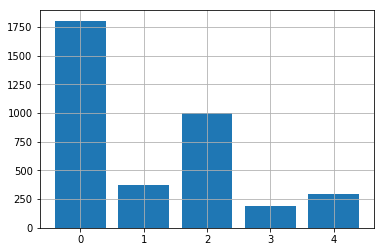

In [16]:
plot_bar(train_data['diagnosis'])

### Add flipped images
Dublicate the images from class 1 to 4 by vertical flip every image.

In [17]:
list_flip = train_data[train_data['diagnosis'] != 0]

In [18]:
X_train_org = add_flip_image(X_train_org, list_flip)
train_data = train_data.append(list_flip, ignore_index=True, sort=False)

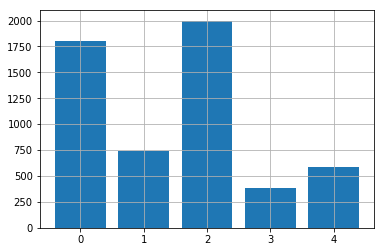

In [19]:
plot_bar(train_data['diagnosis'])

### Add rotated images
Dublicate the images from class 1, 3 and 4 by rotate every image.

In [20]:
list_rot = train_data[(train_data['diagnosis'] != 0)&
                      (train_data['diagnosis'] != 2)]

In [21]:
X_train_org = add_rot_image(X_train_org, list_rot)
train_data = train_data.append(list_rot, ignore_index=True, sort=False)

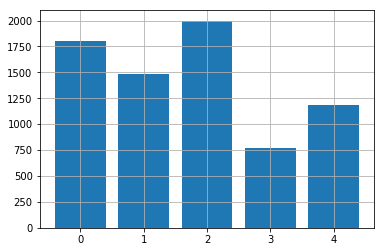

In [22]:
plot_bar(train_data['diagnosis'])

### Add images by zooming
Dublicate the images from class 3 and 4 by zooming every image.

In [23]:
list_zoom = train_data[(train_data['diagnosis'] == 3)|
                       (train_data['diagnosis'] == 4)]

In [24]:
X_train_org = add_zoom_image(X_train_org, list_zoom)
train_data = train_data.append(list_zoom, ignore_index=True, sort=False)

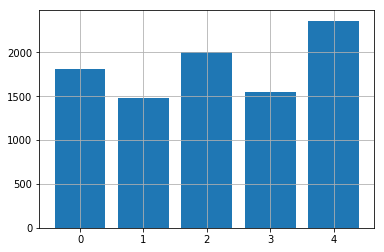

In [25]:
plot_bar(train_data['diagnosis'])

### Select random images for train
The aim is to get equally distributed images for every class.

In [26]:
num_val = (train_data['diagnosis'].value_counts()).min()
list_new = []
for i in range(num_classes):
    temp = random.choices(train_data[train_data['diagnosis']==i].index, k=num_val)
    list_new.extend(temp)
train_data = train_data.loc[list_new]
X_train_org = X_train_org[list_new]

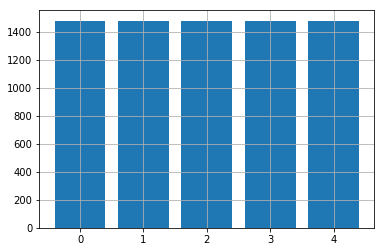

In [27]:
plot_bar(train_data['diagnosis'])

### Plot an image

id_code      c52bb7343387
diagnosis               2
Name: 2836, dtype: object


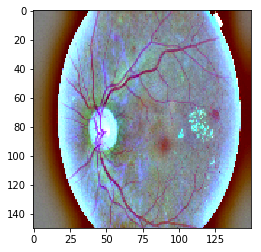

In [28]:
image_number=4019
print(train_data.iloc[image_number])
plt.imshow(X_train_org[image_number], cmap='gray')
plt.show()

### Prepare the labels
Using multi-label instead of single-label.

In [29]:
train_data['multilabel'] = train_data['diagnosis'].apply(get_multilabel)

In [30]:
category =['0','1','2','3','4']
MLB = MultiLabelBinarizer(category)
y_train_org_multi = MLB.fit_transform(train_data['multilabel']).astype('float32')

### Define class weights

In [31]:
class_weight = dict(zip(range(0, num_classes), (((train_data['diagnosis'].value_counts()).sort_index())/len(train_data)).tolist()))

### Convert and scale image data

In [32]:
mean = X_train_org.mean(axis=0)
X_train_org = X_train_org.astype('float32')
X_train_org -= X_train_org.mean(axis=0)
std = X_train_org.std(axis=0)
X_train_org /= X_train_org.std(axis=0)
X_test = X_test.astype('float32')
X_test -= mean
X_test /= std

### Split train and validation data

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train_org, y_train_org_multi,
                                                  test_size=0.1, random_state=0)

### Create the model

In [40]:
conv_base = VGG19(weights='/kaggle/input/keras-models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False,
                  input_shape=(q_size, q_size, img_channel))
conv_base.trainable = True

In [61]:
densenet = DenseNet121(
    weights='/kaggle/input/tf-keras-pretrained-model-weights/No Top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(q_size, q_size, img_channel)
)
densenet.trainable = True

In [42]:
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='sigmoid'))

In [83]:
model2 = Sequential()
model2.add(densenet)
model2.add(layers.GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='sigmoid'))

In [78]:
# # del model1
# del model2

In [48]:
model1.compile(optimizer = Adam(lr=5e-7),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [84]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0000005),
    metrics=['accuracy']
)

In [50]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 24,221,765
Trainable params: 24,221,765
Non-trainable params: 0
_________________________________________________________________


In [85]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [54]:
epochs = 50
batch_size = 32

### Train the model

In [55]:
history1 = model1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 6660 samples, validate on 740 samples
Epoch 1/50
6660/6660 [==============================] - 50s 7ms/step - loss: 0.1123 - binary_accuracy: 0.7164 - val_loss: 0.4021 - val_binary_accuracy: 0.8184
Epoch 2/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0860 - binary_accuracy: 0.7990 - val_loss: 0.3337 - val_binary_accuracy: 0.8562
Epoch 3/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0735 - binary_accuracy: 0.8344 - val_loss: 0.2843 - val_binary_accuracy: 0.8773
Epoch 4/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0648 - binary_accuracy: 0.8548 - val_loss: 0.2510 - val_binary_accuracy: 0.8876
Epoch 5/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0583 - binary_accuracy: 0.8714 - val_loss: 0.2290 - val_binary_accuracy: 0.8995
Epoch 6/50
6660/6660 [==============================] - 33s 5ms/step - loss: 0.0538 - binary_accuracy: 0.8834 - val_loss: 0.2155 - val_binary_accuracy: 0.9049

In [86]:
history2 = model2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 6660 samples, validate on 740 samples
Epoch 1/50
6660/6660 [==============================] - 89s 13ms/step - loss: 0.1855 - acc: 0.5175 - val_loss: 0.7963 - val_acc: 0.5554
Epoch 2/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1657 - acc: 0.5692 - val_loss: 0.7149 - val_acc: 0.6124
Epoch 3/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1477 - acc: 0.6143 - val_loss: 0.6433 - val_acc: 0.6659
Epoch 4/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1338 - acc: 0.6581 - val_loss: 0.5811 - val_acc: 0.7197
Epoch 5/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1230 - acc: 0.6916 - val_loss: 0.5318 - val_acc: 0.7600
Epoch 6/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1149 - acc: 0.7208 - val_loss: 0.4889 - val_acc: 0.7914
Epoch 7/50
6660/6660 [==============================] - 36s 5ms/step - loss: 0.1071 - acc: 0.7475 - val_loss: 0.4549 - val_acc: 0.8105
Epoch 8

### Predict on the test images

In [87]:
y_test1 = model1.predict(X_test)

In [88]:
y_test2 = model2.predict(X_test)

In [89]:
y_op1 = model1.predict(X_val)
y_op_classes1 = np.where(y_op1>0.5, 1, 0).sum(axis=1)-1
y_val_classes1 = np.where(y_val>0.5, 1, 0).sum(axis=1)-1

In [90]:
y_op2 = model2.predict(X_val)
y_op_classes2 = np.where(y_op2>0.5, 1, 0).sum(axis=1)-1
y_val_classes2 = np.where(y_val>0.5, 1, 0).sum(axis=1)-1

In [94]:
y_test_classes1 = np.where(y_test1>0.5, 1, 0).sum(axis=1)-1
y_test_classes2 = np.where(y_test2>0.5, 1, 0).sum(axis=1)-1

### Write output for submission

In [98]:
output1 = pd.DataFrame({'id_code': sub_org['id_code'],
                       'diagnosis': y_test_classes1})
output2 = pd.DataFrame({'id_code': sub_org['id_code'],
                       'diagnosis': y_test_classes2})
#output.to_csv('submission.csv', index=False)

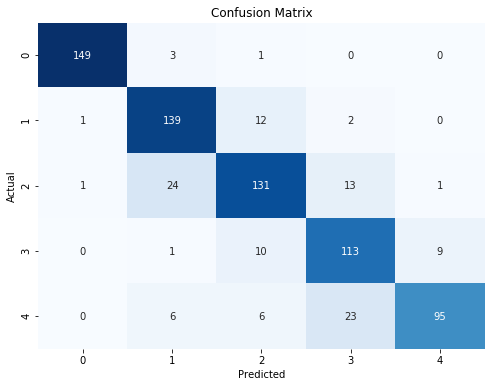

In [95]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_classes1, y_op_classes1)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

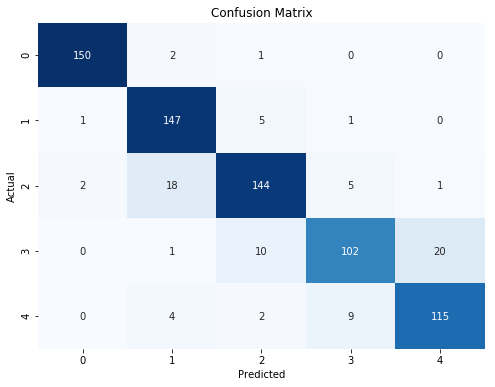

In [96]:
conf_matrix = confusion_matrix(y_val_classes2, y_op_classes2)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

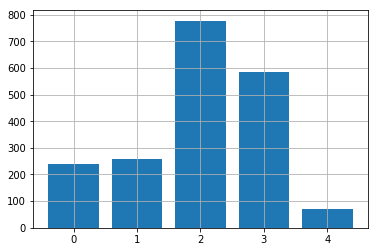

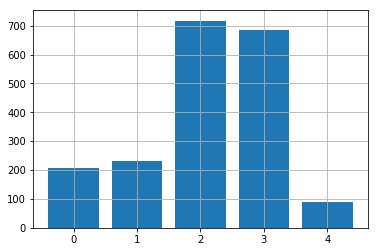

In [99]:
plot_bar(output1['diagnosis'])
plot_bar(output2['diagnosis'])

### Visualize the results

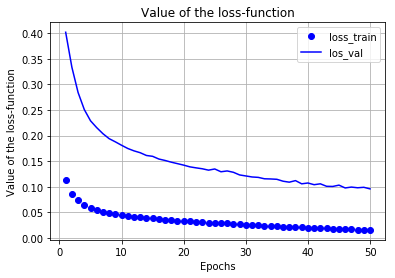

In [100]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='los_val')
plt.title('Value of the loss-function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss-function')
plt.legend()
plt.grid()
plt.show()

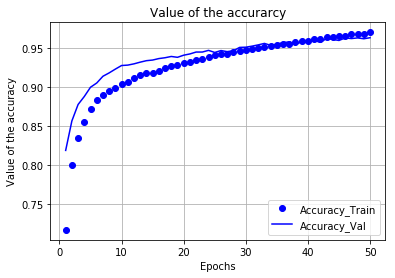

In [101]:
acc = history1.history['binary_accuracy']
acc_val = history1.history['val_binary_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Accuracy_Train')
plt.plot(epochs, acc_val, 'b', label='Accuracy_Val')
plt.title('Value of the accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Value of the accuracy')
plt.legend()
plt.grid()
plt.show()

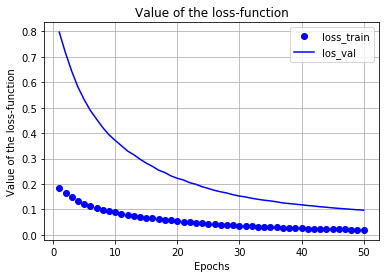

In [102]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='los_val')
plt.title('Value of the loss-function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss-function')
plt.legend()
plt.grid()
plt.show()

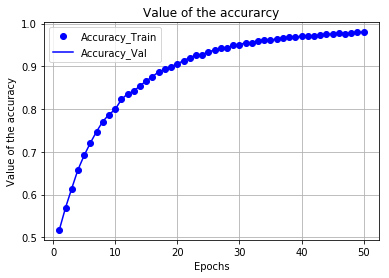

In [104]:
acc = history2.history['acc']
acc_val = history2.history['acc']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Accuracy_Train')
plt.plot(epochs, acc_val, 'b', label='Accuracy_Val')
plt.title('Value of the accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Value of the accuracy')
plt.legend()
plt.grid()
plt.show()